Import configs

In [ ]:
# Core neuromaps modules
from neuromaps.datasets import fetch_annotation, fetch_atlas
from neuromaps.transforms import (
    fsaverage_to_fslr,
    fslr_to_fslr,
    civet_to_fslr,
)
from neuromaps.images import load_data, load_gifti
from neuromaps.stats import compare_images  # optional, for later correlations
from neuromaps.parcellate import Parcellater  # optional, for future analyses
from neuromaps import transforms  # optional, for direct access to transform functions

# Standard libraries
import os
from pathlib import Path

# Numeric and plotting
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

import os

# Add Connectome Workbench to PATH for neuromaps
os.environ["PATH"] = "/Applications/Workbench/bin_macosxub:" + os.environ["PATH"]

# Test that wb_command is now visible
import subprocess
subprocess.run(["wb_command", "-version"])


Connectome Workbench
Type: Command Line Application
Version: 2.0.1
Qt Compiled Version: 6.2.3
Qt Runtime Version: 6.2.3
Commit: 150de12f4f4b94b39bec6d9133ad2e7019d2d3ef
Commit Date: 2024-10-15 17:38:41 -0500
Compiler: c++ (/Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin)
Compiler Version: 13.0.0.13000029
Compiled Debug: NO
Operating System: Apple OSX
Compiled with OpenMP: YES


CompletedProcess(args=['wb_command', '-version'], returncode=0)

## Background

In the neuromaps paper, when comparing a source map (e.g., the schizophrenia map in MNI152) to multiple target maps, they always transformed the source map into the coordinate system of the target map.

However, for our source map (hcps1200 thickness fsLR 32k) and most target maps are already in surface spaces (fsLR, fsaverage, CIVET), and sometimes even the same one. So, we just apply that same rule logically but adapt it based on resolution.

Rules:
- If target and source share the same space and density → no transformation.
- If they share the same space but different densities → transform the higher-resolution dataset to the lower-resolution one.
- If they are in different spaces (fsaverage, CIVET, MNI152) → transform the target map to the source’s space (fsLR 32k).
This keeps everything aligned to a single reference grid for correlation

Assessing the impact of coordinate system
When transforming two datasets (that is, a source and target dataset) defined in distinct coordinate spaces to a common system there are at least three options available: transform the source dataset to the system of the target, transform the target dataset to the system of the source, or transform both source and target datasets to an alternate system. If comparisons are being made across several pairs of datasets a fourth option becomes available: always transform the higher resolution dataset to the system of the lower-resolution dataset.

## Source Map

In [3]:
src_thick = fetch_annotation(source='hcps1200', desc='thickness', space='fsLR', den='32k')
ref_space = ("fsLR", "32k")


[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jesper Andersson, Christian F Beckmann, Mark Jenkinson, and others. A multi-modal parcellation of human cerebral cortex. Nature, 536(7615):171–178, 2016.
  [secondary]:
    


## Target Maps

| #      | Category                                               | Source          | Description                | Space     | Density |
| ------ | ------------------------------------------------------ | --------------- | -------------------------- | --------- | ------- |
| **1**  | Genomics / PC1                                         | `abagen`        | `genepc1`                  | fsaverage | 10k     |
| **2**  | T1w/T2w Ratio (Myelin Map)                             | `hcps1200`      | `myelinmap`                | fsLR      | 32k     |
| **3**  | Cortical Thickness                                     | `hcps1200`      | `thickness`                | fsLR      | 32k     |
| **4**  | Developmental Expansion                                | `hill2010`      | `devexp`                   | fsLR      | 164k    |
| **5**  | Evolutionary Expansion (Human–Macaque)                 | `hill2010`      | `evoexp`   | fsLR      | 164k     |
| **6**  | Functional Gradient (PC1)                              | `margulies2016` | `fcgradient01`  | fsLR      | 32k     |
| **7**  | Intersubject Variability                               | `mueller2013`   | `intersubjvar` | fsLR      | 164k     |
| **8**  | Cerebral Blood Flow (CBF)                              | `raichle`       | `cbf`                      | fsLR      | 164k    |
| **9**  | Cerebral Blood Volume (CBV)                            | `raichle`       | `cbv`                      | fsLR      | 164k    |
| **10** | Oxygen Metabolism (CMRO₂)                              | `raichle`       | `cmr02`                    | fsLR      | 164k    |
| **11** | Glucose Metabolism (CMRGLC)                            | `raichle`       | `cmrglc`                   | fsLR      | 164k    |
| **12** | NIH Allometric Scaling (Developmental Expansion Proxy) | `reardon2018`   | `scalingnih`               | CIVET     | 41k     |
| **13** | PNC Allometric Scaling                                 | `reardon2018`   | `scalingpnc`               | CIVET     | 41k     |


## Transformations

### PC1 gene expression

In [4]:
genepc1 = fetch_annotation(source='abagen', desc='genepc1', space='fsaverage', den='10k')
genepc1_fsLR32k = fsaverage_to_fslr(genepc1, target_density='32k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'}:
  [primary]:
    Michael J Hawrylycz, Ed S Lein, Angela L Guillozet-Bongaarts, Elaine H Shen, Lydia Ng, Jeremy A Miller, Louie N Van De Lagemaat, Kimberly A Smith, Amanda Ebbert, Zackery L Riley, and others. An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416):391, 2012.
    Ross D Markello, Aurina Arnatkeviciute, Jean-Baptiste Poline, Ben D Fulcher, Alex Fornito, and Bratislav Misic. Standardizing workflows in imaging transcriptomics with the abagen toolbox. eLife, 10:e72129, 2021.
  [secondary]:
    



[References] Please cite the following papers if you are using this data:

  For {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'}:
  [primary]:
    Michael J Hawrylycz, Ed S Lein, Angela L Guillozet-Bongaarts, Elaine H Shen, Lydia Ng, Jeremy A Miller, Louie N Van De Lagemaat, Kimberly A Smith, Amanda Ebbert, Zackery L Riley, and others. An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416):391, 2012.
    Ross D Markello, Aurina Arnatkeviciute, Jean-Baptiste Poline, Ben D Fulcher, Alex Fornito, and Bratislav Misic. Standardizing workflows in imaging transcriptomics with the abagen toolbox. eLife, 10:e72129, 2021.
  [secondary]:
    


/var/folders/bt/jnhv97x567d_zw77p84pr9v40000gn/T/ipykernel_94671/3770379975.py:19: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(
/var/folders/bt/jnhv97x567d_zw77p84pr9v40000gn/T/ipykernel_94671/3770379975.py:29: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(


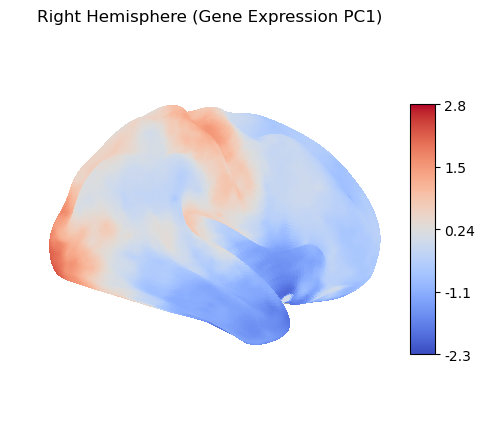

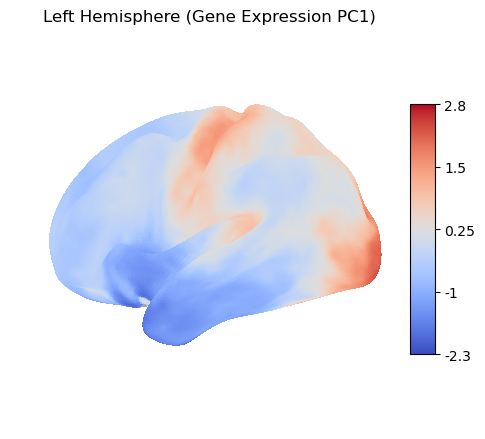

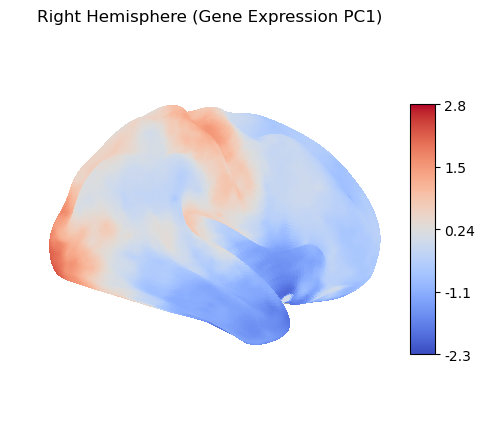

In [26]:
from nilearn import plotting
from neuromaps.datasets import fetch_annotation, fetch_atlas
from neuromaps.transforms import fsaverage_to_fslr
from neuromaps.images import load_data

# Step 1: Fetch and transform to fsLR 32k
genepc1 = fetch_annotation(source='abagen', desc='genepc1', space='fsaverage', den='10k')
genepc1_fsLR32k = fsaverage_to_fslr(genepc1, target_density='32k')

# Step 2: Load fsLR surface geometry (inflated)
atlas = fetch_atlas('fsLR', '32k')
surf_left = atlas['inflated'].L
surf_right = atlas['inflated'].R

# Step 3: Extract data arrays
data_left, data_right = [load_data(f) for f in genepc1_fsLR32k]

# Step 4: Plot left hemisphere
plotting.plot_surf(
    surf_left, data_left,
    hemi='left',
    view='lateral',
    cmap='coolwarm',
    colorbar=True,
    title='Left Hemisphere (Gene Expression PC1)'
)

# Step 5: Plot right hemisphere
plotting.plot_surf(
    surf_right, data_right,
    hemi='right',
    view='lateral',
    cmap='coolwarm',
    colorbar=True,
    title='Right Hemisphere (Gene Expression PC1)'
)


### T1w/T2w ratio (Myelin map)

In [5]:
myelinmap = fetch_annotation(source='hcps1200', desc='myelinmap', space='fsLR', den='32k')
myelinmap_fsLR32k = myelinmap  # already in target space



[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'myelinmap', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jesper Andersson, Christian F Beckmann, Mark Jenkinson, and others. A multi-modal parcellation of human cerebral cortex. Nature, 536(7615):171–178, 2016.
  [secondary]:
    


### Cortical thickness

In [6]:
thickness = fetch_annotation(source='hcps1200', desc='thickness', space='fsLR', den='32k')
thickness_fsLR32k = thickness  # already in target space


[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jesper Andersson, Christian F Beckmann, Mark Jenkinson, and others. A multi-modal parcellation of human cerebral cortex. Nature, 536(7615):171–178, 2016.
  [secondary]:
    


### Developmental expansion (PNC)



In [7]:
devexp = fetch_annotation(source='hill2010', desc='devexp', space='fsLR', den='164k')
print(type(devexp), devexp)


[References] Please cite the following papers if you are using this data:

  For {'source': 'hill2010', 'desc': 'devexp', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    Jason Hill, Terrie Inder, Jeffrey Neil, Donna Dierker, John Harwell, and David Van Essen. Similar patterns of cortical expansion during human development and evolution. Proceedings of the National Academy of Sciences, 107(29):13135–13140, 2010.
  [secondary]:
    
<class 'str'> /Users/katy/neuromaps-data/annotations/hill2010/devexp/fsLR/source-hill2010_desc-devexp_space-fsLR_den-164k_hemi-R_feature.func.gii


Because hill2010/devexp only exists for the right hemisphere we transformed it like this:

In [16]:
devexp = fetch_annotation(source='hill2010', desc='devexp', space='fsLR', den='164k')
devexp_fsLR = fslr_to_fslr(devexp, '32k', hemi='R')


[References] Please cite the following papers if you are using this data:

  For {'source': 'hill2010', 'desc': 'devexp', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    Jason Hill, Terrie Inder, Jeffrey Neil, Donna Dierker, John Harwell, and David Van Essen. Similar patterns of cortical expansion during human development and evolution. Proceedings of the National Academy of Sciences, 107(29):13135–13140, 2010.
  [secondary]:
    


### Evolutionary expansion



In [17]:
evoexp = fetch_annotation(source='hill2010', desc='evoexp', space='fsLR', den='164k')
evoexp_fsLR32k = evoexp


[fetch_single_file] Downloading data from 
https://files.osf.io/v1/resources/4mw3a/providers/osfstorage/6130ff02ab8bca0212ee54f8 ...

[fetch_single_file]  ...done. (2 seconds, 0 min)


[References] Please cite the following papers if you are using this data:

  For {'source': 'hill2010', 'desc': 'evoexp', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    Jason Hill, Terrie Inder, Jeffrey Neil, Donna Dierker, John Harwell, and David Van Essen. Similar patterns of cortical expansion during human development and evolution. Proceedings of the National Academy of Sciences, 107(29):13135–13140, 2010.
  [secondary]:
    


### Functional gradient (FC grad 1)



In [15]:
gradient_pc1 = fetch_annotation(source='margulies2016', desc='fcgradient01', space='fsLR', den='32k')
gradient_pc1_fsLR32k = gradient_pc1



[References] Please cite the following papers if you are using this data:

  For {'source': 'margulies2016', 'desc': 'fcgradient01', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Daniel S Margulies, Satrajit S Ghosh, Alexandros Goulas, Marcel Falkiewicz, Julia M Huntenburg, Georg Langs, Gleb Bezgin, Simon B Eickhoff, F Xavier Castellanos, Michael Petrides, and others. Situating the default-mode network along a principal gradient of macroscale cortical organization. Proc Natl Acad Sci USA, 113(44):12574–12579, 2016.
  [secondary]:
    


### Intersubject variability



In [13]:
isv = fetch_annotation(source='mueller2013', desc='intersubjvar', space='fsLR', den='164k')
isv_fsLR32k = fslr_to_fslr(isv, target_density='32k')

[fetch_single_file] Downloading data from 
https://files.osf.io/v1/resources/4mw3a/providers/osfstorage/6130ff274e5ee50219291de1 ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

[fetch_single_file] Downloading data from 
https://files.osf.io/v1/resources/4mw3a/providers/osfstorage/6130ff33ab8bca0225edc685 ...

[fetch_single_file]  ...done. (2 seconds, 0 min)


[References] Please cite the following papers if you are using this data:

  For {'source': 'mueller2013', 'desc': 'intersubjvar', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    Sophia Mueller, Danhong Wang, Michael D Fox, BT Thomas Yeo, Jorge Sepulcre, Mert R Sabuncu, Rebecca Shafee, Jie Lu, and Hesheng Liu. Individual variability in functional connectivity architecture of the human brain. Neuron, 77(3):586–595, 2013.
  [secondary]:
    


### Cerebral blood flow (CBF)



In [ ]:
cbf = fetch_annotation(source='raichle', desc='cbf', space='fsLR', den='164k')
cbf_fsLR32k = fslr_to_fslr(cbf, target_density='32k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'raichle', 'desc': 'cbf', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    S Neil Vaishnavi, Andrei G Vlassenko, Melissa M Rundle, Abraham Z Snyder, Mark A Mintun, and Marcus E Raichle. Regional aerobic glycolysis in the human brain. Proceedings of the National Academy of Sciences, 107(41):17757–17762, 2010.
  [secondary]:
    


### Cerebral blood volume (CBV)



In [ ]:
cbv = fetch_annotation(source='raichle', desc='cbv', space='fsLR', den='164k')
cbv_fsLR32k = fslr_to_fslr(cbv, target_density='32k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'raichle', 'desc': 'cbv', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    S Neil Vaishnavi, Andrei G Vlassenko, Melissa M Rundle, Abraham Z Snyder, Mark A Mintun, and Marcus E Raichle. Regional aerobic glycolysis in the human brain. Proceedings of the National Academy of Sciences, 107(41):17757–17762, 2010.
  [secondary]:
    


### Oxygen metabolism (CMRO2)



In [ ]:
cmro2 = fetch_annotation(source='raichle', desc='cmr02', space='fsLR', den='164k')
cmro2_fsLR32k = fslr_to_fslr(cmro2, target_density='32k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'raichle', 'desc': 'cmr02', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    S Neil Vaishnavi, Andrei G Vlassenko, Melissa M Rundle, Abraham Z Snyder, Mark A Mintun, and Marcus E Raichle. Regional aerobic glycolysis in the human brain. Proceedings of the National Academy of Sciences, 107(41):17757–17762, 2010.
  [secondary]:
    


### Glucose metabolism (CMRGlu)



In [ ]:
cmrglc = fetch_annotation(source='raichle', desc='cmrglc', space='fsLR', den='164k')
cmrglc_fsLR32k = fslr_to_fslr(cmrglc, target_density='32k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'raichle', 'desc': 'cmrglc', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    S Neil Vaishnavi, Andrei G Vlassenko, Melissa M Rundle, Abraham Z Snyder, Mark A Mintun, and Marcus E Raichle. Regional aerobic glycolysis in the human brain. Proceedings of the National Academy of Sciences, 107(41):17757–17762, 2010.
  [secondary]:
    


### Allometric scaling (NIH)



In [ ]:
scalingnih = fetch_annotation(source='reardon2018', desc='scalingnih', space='civet', den='41k')
scalingnih_fsLR32k = civet_to_fslr(scalingnih, target_density='32k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'reardon2018', 'desc': 'scalingnih', 'space': 'civet', 'den': '41k'}:
  [primary]:
    PK Reardon, Jakob Seidlitz, Simon Vandekar, Siyuan Liu, Raihaan Patel, Min Tae M Park, Aaron Alexander-Bloch, Liv S Clasen, Jonathan D Blumenthal, Francois M Lalonde, and others. Normative brain size variation and brain shape diversity in humans. Science, 360(6394):1222–1227, 2018.
  [secondary]:
    


### Allometric scaling (PNC)



In [ ]:
scalingpnc = fetch_annotation(source='reardon2018', desc='scalingpnc', space='civet', den='41k')
scalingpnc_fsLR32k = civet_to_fslr(scalingpnc, target_density='32k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'reardon2018', 'desc': 'scalingpnc', 'space': 'civet', 'den': '41k'}:
  [primary]:
    PK Reardon, Jakob Seidlitz, Simon Vandekar, Siyuan Liu, Raihaan Patel, Min Tae M Park, Aaron Alexander-Bloch, Liv S Clasen, Jonathan D Blumenthal, Francois M Lalonde, and others. Normative brain size variation and brain shape diversity in humans. Science, 360(6394):1222–1227, 2018.
  [secondary]:
    
